<a href="https://colab.research.google.com/github/NoCodeProgram/deepLearning/blob/main/transformer/segformerFinetun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(512, 512)


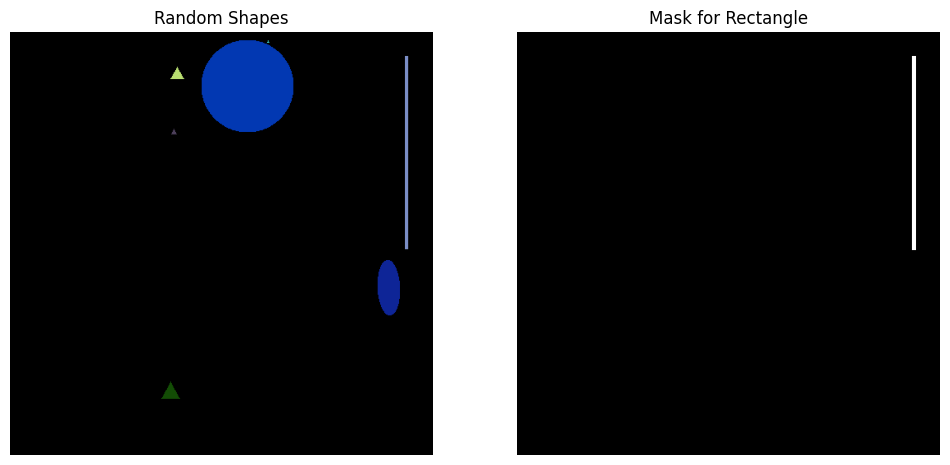

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import random_shapes, rectangle

def generate_segmentation_rect(image_size):
    image, labels = random_shapes(image_size, max_shapes=10, min_shapes=5,  allow_overlap=False)
    image = 255 - image

    mask = np.zeros(image.shape[:2], dtype=float)
    for shape, ((start_row, end_row), (start_col, end_col)) in labels:
        if shape == "rectangle":
            # print(shape, ((start_row, start_col), (end_row, end_col)) )
            rr, cc = rectangle(start=(start_row, start_col),
                                    end=(end_row, end_col),
                                    shape=image_size)
            mask[rr, cc] = 1.0

    return image, mask

image_size = (512, 512)
image, mask = generate_segmentation_rect(image_size)
print(mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Random Shapes')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask for Rectangle')
ax[1].axis('off')

plt.show()

In [ ]:
import torch

# Check for MPS (Apple Silicon) or CUDA
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

def get_batch_tensor(batch_size=8):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    images = []
    labels = []

    # Generate batch of images and labels
    for _ in range(batch_size):
        image, label = generate_segmentation_rect(image_size)

        tensor_image = TF.to_tensor(image)
        normalized_image = normalize(tensor_image)
        tensor_label = torch.from_numpy(label).long()


        images.append(normalized_image)
        labels.append(tensor_label)

    batch_images = torch.stack(images)
    batch_labels = torch.stack(labels)

    return batch_images, batch_labels

batch_images, batch_labels = get_batch_tensor(8)

In [ ]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation


# Initialize model
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.to(device)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.lin

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [ ]:
from tqdm.notebook import tqdm

# Setup optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 20
batch_size = 16
num_iterations_per_epoch = 50

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(range(num_iterations_per_epoch),
                      desc=f"Epoch {epoch+1}/{num_epochs}")

    for _ in progress_bar:
        # Generate batch
        batch_images, batch_labels = get_batch_tensor(batch_size)
        # Handle MPS device type for Apple Silicon
        if device.type == "mps":
            batch_images = batch_images.to(device, dtype=torch.float32)
            batch_labels = batch_labels.to(device, dtype=torch.long)
        else:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(pixel_values=batch_images, labels=batch_labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

Epoch 1/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/50 [00:00<?, ?it/s]

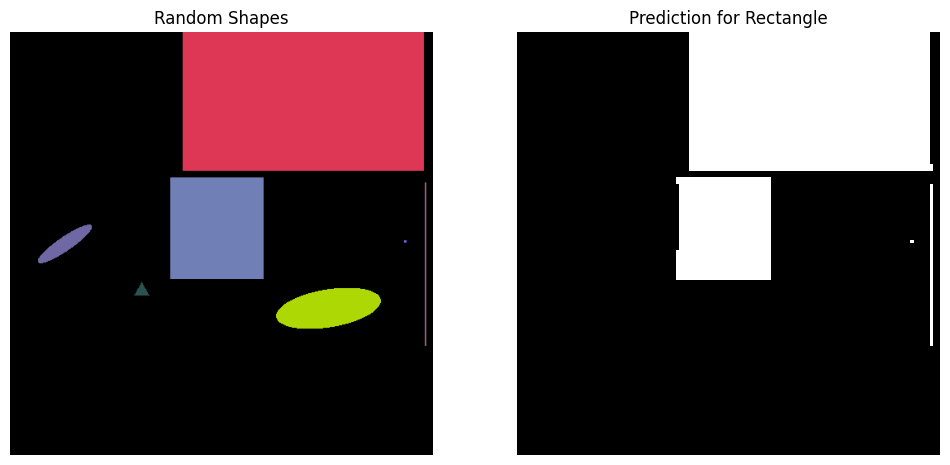

In [ ]:
# Move model to CPU
model.eval()
model.to('cpu')

# Get a single image
image, mask = get_batch_tensor(1)

# Get prediction
with torch.no_grad():
    outputs = model(pixel_values=image)  # Segformer uses pixel_values
    logits = outputs.logits  # Get logits from Segformer output

# Process image for display
image = image.squeeze().cpu().numpy()
image = image.transpose(1, 2, 0)
# Denormalize image
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)

# Process prediction
prediction = logits.squeeze().cpu().numpy()
prediction = np.argmax(prediction, axis=0)
prediction = prediction * 255  # Scale to 0-255 range
prediction = prediction.astype(np.uint8)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Random Shapes')
ax[0].axis('off')

ax[1].imshow(prediction, cmap='gray')
ax[1].set_title('Prediction for Rectangle')
ax[1].axis('off')

plt.show()